In [1]:
# ----------------------------------------------------- #
# ------- BEGIN: MAIN FUNCTIONS AND DEFINITIONS ------- #
# ----------------------------------------------------- #

In [2]:
#
# Label of an edge joining roots u and v
#
def label(u,v):
    return bL(u,v)**2/fL(u)/fL(v); # value of cos^2 or cosh^2 

In [3]:
#
# Constructing a diagram using outer normals of a polytope
#
# Labels are given by squares of inner products of normals
#
def diagram(normals):
    g = Graph();
    l = len(normals);
    for i in range(l):
        for j in range(l):
            if i<j:
                lb = label(normals[i],normals[j]);
                g.add_vertices([i,j]);
                if lb!=0:
                    g.add_edge(i,j,lb);
    return g;

In [4]:
#
# Is a given polytope of Coxeter type ?
#
def isCoxeter(normals):
    l = len(normals);
    for i in range(l):
        for j in range(l):
            if i<j:
                u = normals[i];
                v = normals[j];
                weight = bL(u,v)**2/fL(u)/fL(v);
                if weight < 1:
                    k = round(pi/arccos(sqrt(weight)));
                    if not(minpoly(weight)==minpoly(cos(pi/k)**2)):
                        return False;
    return True;

In [5]:
#
# Coxeter diagram using outer normals of a polytope
#
# IMPORTANT:
# This routine _does__not_ check if normals indeed
# define a Coxeter polytope: use isCoxeter instead!
#
# Labels are integers:
# n\geq 3 : angle of \pi/n
# n = 0 : angle of 0, label \infinity, or bold edge
# n = 1 : common perpendicular, dotted edge
#
def Coxeter_diagram(normals):
    g = Graph();
    l = len(normals);
    for i in range(l):
        for j in range(l):
            if (i<j):
                u = normals[i];
                v = normals[j];
                weight = bL(u,v)**2/fL(u)/fL(v);
                if weight<1:
                    k = round(pi/arccos(sqrt(weight)));
                    g.add_vertex(i);
                    g.add_vertex(j);
                    if k>2:
                        g.add_edge(i,j,k);
                else:
                    if weight==1:
                        g.add_edge(i,j,0);
                    else:
                        g.add_edge(i,j,1);
    return g;

In [6]:
#
# Gram matrix of a polytope
#
def Gram_matrix(normals):
    l = len(normals);
    m = matrix(l, l, [symbolic_expression(bL(normals[i],normals[j])/sqrt(fL(normals[i])*fL(normals[j]))).canonicalize_radical() for i in range(l) for j in range(l)]);
    return m;

In [7]:
#
# Projecting vector w onto __orthogonal__complement__ of W
#
def proj(w, W): 
    ww = sum([bL(vv,w)/fL(vv)*vv for vv in W]);
    return w - ww;

In [8]:
#
# Producing the list of facets of a polytope given as 
# (set of normals of sub-face, its diagram, symmetry group,
# index of normal vector of super-face, angles between sub-face and its neighbours).
#
# Here, the first 3 entries represent the most important data, while the last two 
# are useful for tracing adjacency and play the role of auxiliary data. 
#
# All angles between the sub-face and its neighbours are given as k, for an angle of \pi/k.  
#
# Each isometry type of a facet happens only __once__
#
def facets(normals, diag, aut, ind, angles):
    f_list = [];
    f = list(map(lambda x: sorted(x)[0], aut.orbits()));
    for i in f:
        f_poly = [proj(w, [normals[i]]) for w in normals if bL(w,normals[i])**2/fL(w)/fL(normals[i])<1];
        d_poly = diagram(f_poly);
        a_poly = d_poly.automorphism_group(edge_labels=True);
        ang_poly = [bL(w,normals[i])**2/fL(w)/fL(normals[i]) for w in normals if bL(w,normals[i])**2/fL(w)/fL(normals[i])<1];
        ang_poly = list(map(lambda x: round(pi/arccos(sqrt(x))), ang_poly));
        flag = True;
        count = 0;
        while flag and (count<len(f_list)):            
            flag = flag and not(d_poly.is_isomorphic(f_list[count][1]));
            count += 1;
        if flag:
            f_list += [(f_poly, d_poly, a_poly, i, ang_poly)];
    return f_list;

In [9]:
#
# Augmenting the facet tree
#
# IMPORTANT: vertices are enumerated in no particular order
#
def augment_facet_tree(T):
    max_dist = max([T.distance(0,t) for t in T.vertices()]);
    for t in T.vertices():
        if T.distance(0,t)==max_dist:
            m = max(T.vertices());
            s = facets(*T.get_vertex(t));
            for i in range(len(s)):
                T.add_edge(t, m+i+1);
                T.set_vertex(m+i+1, s[i]);

In [10]:
#
# Pruning the facet tree: removing repeated isometry types of non-Coxeter descendants
#
# IMPORTANT: vertices are enumerated in no particular order
#
def prune_facet_tree(T):
    leaves = [t for t in T.vertices() if T.degree(t)<2 and t!=0];
    pruned = [];
    for l in leaves:
        if isCoxeter(T.get_vertex(l)[0]): # we do not prune Coxeter "leaves"
            pruned += [l];
        else:
            if all([not T.get_vertex(l)[1].is_isomorphic(T.get_vertex(ll)[1], edge_labels=True) for ll in pruned]):
                pruned += [l];
    for l in leaves:
        if not(l in pruned):
            T.delete_vertex(l);

In [11]:
#
# Veryfying arithmeticity of faces in the facet tree
#
# IMPORTANT: here we assume that the initial polytope is an acute-angled quasi-arithmetic polytope, and 
# thus conditions (V1)--(V2) from Vinberg's criterion are __not__ verified. Only (V3) is checked 
#
def isArithmetic(diag, verbose=False): 
    if diag.size() > 30: # this search takes too long for large diagrams, so large diagrams are not checked 
        if verbose:
            print("Face given below is not checked because its diagram is too large");
        return None;     # None is returned if the number of edges is > 30, as an indicator of no check done
    dd = diag.to_directed();
    cyc = dd.all_simple_cycles();
    for c in cyc:
        l = len(c);
        cprod = prod([4*dd.edge_label(c[i],c[(i+1)]) for i in range(l-1)]);
        cprod = K(sqrt(cprod));
        if not(cprod in K.ring_of_integers()):
            if verbose:
                print("Face given below is not arithmetic because of (cycle, cyclic product): ", c, cprod);
            return False;
    return True;

In [12]:
#
# Finding Coxeter faces in the facet tree and veryfying their arithmeticity // proper quasi-arithmeticity
#
# IMPORTANT: here we assume that the initial polytope is an acute-angled quasi-arithmetic polytope, and 
# thus conditions (V1)--(V2) from Vinberg's criterion are __not__ verified. Only (V3) is checked by isArithmetic
#
# Labels for Coxeter diagrams (if plot_diag == True): 
# n\geq 3 : angle of \pi/n
# n = 0 : angle of 0, lable \infinity, or bold edge
# n = 1 : common perpendicular, dotted edge
#
def facet_info(T, plot_diag=False):
    max_dist = max([T.distance(0,t) for t in T.vertices()]);
    print("Codimension", max_dist, "Coxeter faces.");
    for t in T.vertices():
        if T.distance(0,t)==max_dist:
            pp = T.get_vertex(t);
            if isCoxeter(pp[0]):
                flag = isArithmetic(pp[1], verbose=True);
                print("Face ", t, " is arithmetic." if flag else " is not checked." if flag==None else " is (properly) quasi-arithmetic.");
                if (flag!=None)and(plot_diag):
                    print("Coxeter diagram of face ", t);
                    Coxeter_diagram(pp[0]).plot(layout="spring", vertex_labels=False, edge_labels=True).show();

In [13]:
#
# Finding Coxeter faces in the facet tree and verifying their arithmeticity // proper quasi-arithmeticity
#
# IMPORTANT: here we assume that the initial polytope is an acute-angled quasi-arithmetic polytope, and 
# thus conditions (V1)--(V2) from Vinberg's criterion are __not__ verified. Only (V3) is checked by isArithmetic
# 
def color_facets(T):
    color_dict = {'yellow':[], 'lightgreen':[], 'aqua':[], 'red':[]};
    for t in T.vertices():
        if isCoxeter(T.get_vertex(t)[0]):
            flag = isArithmetic(T.get_vertex(t)[1]);
            if flag==None:
                color_dict['red'] += [t];
            else:
                if flag:
                    color_dict['lightgreen'] += [t];
                else:
                    color_dict['aqua']  += [t];
        else:
            color_dict['yellow'] += [t];
    return color_dict;

In [14]:
# --------------------------------------------------- #
# ------- END: MAIN FUNCTIONS AND DEFINITIONS ------- #
# --------------------------------------------------- #

In [15]:
# --------------------------------------------------------------- #
# ------- POLYTOPES: a 7-dimensional polytope by Bugaenko ------- #
# --------------------------------------------------------------- #

In [16]:
#
# Field Q[t], t=\sqrt(5)
#
K.<t> = QuadraticField(5); 
#
# Fundamental unit of K
#
phi = (1+t)/2;
#
# Outer normals to facets
#
e1 = (0, -K(1), K(1), 0, 0, 0, 0, 0);
e2 = (0, 0, -K(1), K(1), 0, 0, 0, 0);
e3 = (0, 0, 0, -K(1), K(1), 0, 0, 0);
e4 = (0, 0, 0, 0, -K(1), K(1), 0, 0);
e5 = (0, 0, 0, 0, 0, -K(1), K(1), 0);
e6 = (0, 0, 0, 0, 0, 0, -K(1), K(1));
e7 = (0, 0, 0, 0, 0, 0, 0, -K(1));
e8 = (2 - 1 * phi, 1 * phi, 0, 0, 0, 0, 0, 0);
e9 = (1 * phi, 1 * phi, 1 * phi, 1 * phi, 1 * phi, 1 * phi, 0, 0);
e10 = (1 + 1 * phi, 1 + 1 * phi, 1 + 1 * phi, 1 + 1 * phi, 1 * phi, 1 * phi, 1 * phi, 1 * phi);
e11 = (2 + 2 * phi, 2 + 2 * phi, 1 + 2 * phi, 1 + 2 * phi, 1 + 2 * phi, 1 + 2 * phi, 1 + 2 * phi, 1);
#
# Creating a list of outer normals (roots)
#
roots = list(map(lambda x: vector(x), [e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11]));
#
# Bilinear form associated with L
#
def bL(u, v):
    return (-1-2*phi)*u[0]*v[0] + u[1:]*v[1:];
#
# Quadratic form associated with L
#
def fL(v):
    return bL(v, v);

In [17]:
#
# Creating the root of the facet tree
#
d7 = diagram(roots);
a7 = d7.automorphism_group(edge_labels=True);
P = (roots, d7, a7, None, None);
#
# Creating the facet tree
#
T = Graph();
T.add_vertex(0);
T.set_vertex(0,P);
#
# Augmenting the facet tree with faces from codim 1 to codim (dim_polytope)-2
#
dim_polytope = 7;
for codim in range(dim_polytope-2):    
    facet_info(T);
    augment_facet_tree(T);
    prune_facet_tree(T);
facet_info(T);

Codimension 0 Coxeter faces.
Face  0  is arithmetic.
Codimension 1 Coxeter faces.
Face  5  is arithmetic.
Codimension 2 Coxeter faces.
Face  13  is arithmetic.
Face  34  is arithmetic.
Face  35  is arithmetic.
Face  38  is arithmetic.
Face  40  is arithmetic.
Face  47  is arithmetic.
Codimension 3 Coxeter faces.
Face  53  is arithmetic.
Face  86  is arithmetic.
Face  88  is arithmetic.
Face  89  is arithmetic.
Face  94  is arithmetic.
Face  96  is arithmetic.
Face  107  is arithmetic.
Face  132  is arithmetic.
Face  167  is arithmetic.
Face  171  is arithmetic.
Face  173  is arithmetic.
Face  174  is arithmetic.
Face  179  is arithmetic.
Face  180  is arithmetic.
Face  185  is arithmetic.
Face  187  is arithmetic.
Face  198  is arithmetic.
Codimension 4 Coxeter faces.
Face  202  is arithmetic.
Face  227  is arithmetic.
Face  229  is arithmetic.
Face  230  is arithmetic.
Face  234  is arithmetic.
Face  236  is arithmetic.
Face  244  is arithmetic.
Face  266  is arithmetic.
Face  323  is

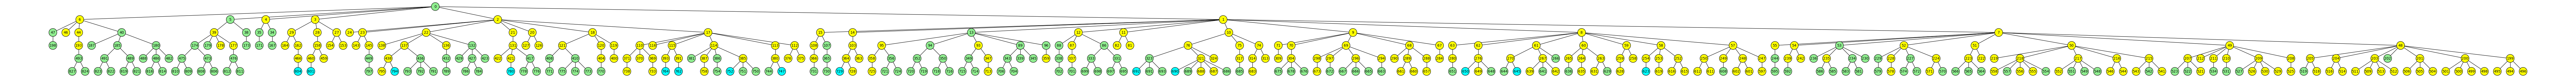

In [18]:
# yellow = non-Coxeter
# green = Coxeter, arithmetic
# blue = Coxeter, non-arithmetic
# red = no check done (diagram too large)
T.plot(layout="tree", tree_root=0, talk=True, vertex_colors=color_facets(T)).show(figsize=[100,100]);

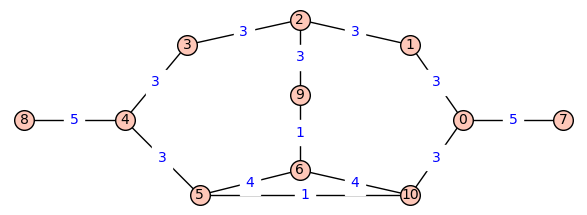

In [19]:
#
# Coxeter diagram of P
#
p = {0: [0.75, 0.7],
 1: [0.54, 1.0],
 2: [0.1, 1.1],
 3: [-0.35, 1.0],
 4: [-0.6, 0.7],
 5: [-0.3, 0.4],
 6: [0.1, 0.5],
 7: [1.15, 0.7],
 8: [-1, 0.7],
 9: [0.1, 0.8],
 10: [0.54, 0.4]};
Coxeter_diagram(T.get_vertex(0)[0]).plot(vertex_labels=True, edge_labels=True, pos=p).show(); 

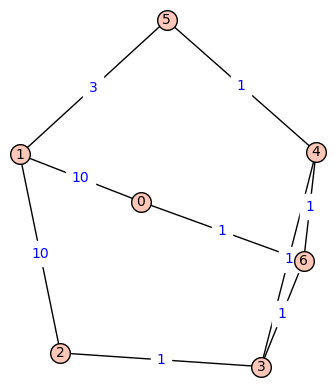

In [20]:
#
# An arithmetic 3-dimensional face P'
# P' is face #323 in the facet tree
#
Coxeter_diagram(T.get_vertex(323)[0]).plot(vertex_labels=True,edge_labels=True).show();

In [21]:
#
# Vertices of the subdiagram of P corresponding to P'
#
print([i for i in range(11) if all([bL(roots[i], v)**2/fL(roots[i])/fL(v) < 1 for v in T.get_vertex(323)[0]])]);

[0, 4, 7, 8]


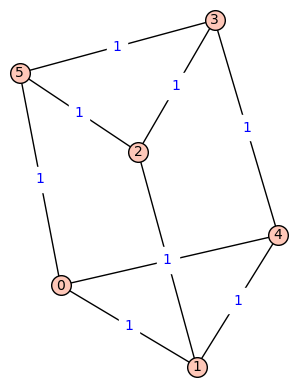

In [22]:
#
# A properly quasi-arithmetic 2-dimensional facet P''_1 of P'
# P''_1 is face #804 in the facet tree of P'
#
Coxeter_diagram(T.get_vertex(692)[0]).plot(vertex_labels=True,edge_labels=True).show();

In [23]:
#
# P''_1 is facet #1 of P' 
#
print(T.get_vertex(692)[3]);
#
# The angles that it forms with its neighbours
# have the following denominators
#
print(set(T.get_vertex(692)[4]));

1
{3, 10, 2}


In [24]:
#
# Gram matrix of P''_1 (face #692)
#
show(Gram_matrix(T.get_vertex(692)[0]));

[                                     1                         -2*sqrt(5) - 5                                      0                                      0 -1/3*5^(1/4)*sqrt(3)/sqrt(sqrt(5) - 2)                         -2*sqrt(5) - 4]
[                        -2*sqrt(5) - 5                                      1                         -2*sqrt(5) - 4                                      0 -1/3*5^(1/4)*sqrt(3)/sqrt(sqrt(5) - 2)                                      0]
[                                     0                         -2*sqrt(5) - 4                                      1             -5^(1/4)/sqrt(sqrt(5) - 1)                                      0                     -3/2*sqrt(5) - 5/2]
[                                     0                                      0             -5^(1/4)/sqrt(sqrt(5) - 1)                                      1     -1/6*sqrt(3)*sqrt(2)*(sqrt(5) + 1)             -5^(1/4)/sqrt(sqrt(5) - 1)]
[-1/3*5^(1/4)*sqrt(3)/sqrt(sqrt(5) - 2) -1/3*5^(1/4)*sqrt(3)/sqrt(sqrt(5) - 2)                                      0     -1/6*sqrt(3)*sqrt(2)*(sqrt(5) + 1)                                      1                                      0]
[                        -2*sqrt(5) - 4                                      0                     -3/2*sqrt(5) - 5/2             -5^(1/4)/sqrt(sqrt(5) - 1)                                      0                                      1]

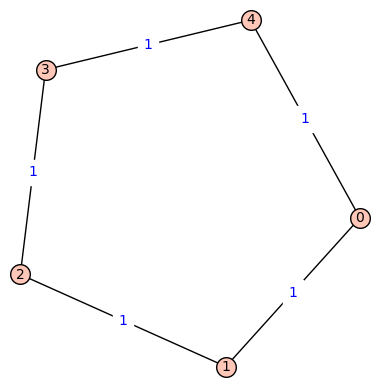

In [25]:
#
# An arithmetic 2-dimensional facet P''_2 of P'
# P''_2 is face #691 in the facet tree of P'
#
Coxeter_diagram(T.get_vertex(691)[0]).plot(vertex_labels=True,edge_labels=True).show();

In [26]:
#
# P''_2 is facet #0 of P' 
#
print(T.get_vertex(691)[3]);
#
# Its angles with neighbours 
# have denominators
#
print(set(T.get_vertex(691)[4]));

0
{10, 2}


In [27]:
#
# Gram matrix of P''_2 (face #691)
#
show(Gram_matrix(T.get_vertex(691)[0]));

[                         1 -5^(1/4)/sqrt(sqrt(5) - 2)                          0                          0         -1/2*sqrt(5) - 1/2]
[-5^(1/4)/sqrt(sqrt(5) - 2)                          1         -1/2*sqrt(5) - 3/2                          0                          0]
[                         0         -1/2*sqrt(5) - 3/2                          1 -5^(1/4)/sqrt(sqrt(5) - 1)                          0]
[                         0                          0 -5^(1/4)/sqrt(sqrt(5) - 1)                          1 -1/4*sqrt(2)*(sqrt(5) + 1)]
[        -1/2*sqrt(5) - 1/2                          0                          0 -1/4*sqrt(2)*(sqrt(5) + 1)                          1]

In [28]:
# --------------------------------------------------------------- #
# ------- POLYTOPES: an 8-dimensional polytope by Bugaenko ------ #
# --------------------------------------------------------------- #

In [29]:
#
# Field Q[t], t=\sqrt(5)
#
K.<t> = QuadraticField(5); 
#
# Fundamental unit of K
#
phi = (1+t)/2;
#
# Standard basis of R^{1,8}
#
v = matrix(K, matrix.identity(9));
#
# Outer normals to facets: e1, ..., e6
#
roots = [];
for i in range(1,7):
    roots.append(-v[i] + v[i+1]); 
#
# Outer normals to facets: e7, e8
#
e7 = -v[6] -v[7];
e8 = (1/2)*(v[1] + v[2] + v[3] + v[4] + v[5] + v[6] + v[7] + v[8]);
#
# Outer normals to facets: e9, ..., e11
#
e9 = v[0] + phi*(v[1] - v[8]);
e10 = phi*v[0] - 2*phi*v[8];
e11 = (3*phi + 2)*v[0] + (phi + 1)*(v[1] + v[2] + v[3]) + phi*(v[4] + v[5] + v[6] - v[7]) - (5*phi + 3)*v[8];
#
# Creating a list of outer normals (roots)
#
roots += [e7, e8, e9, e10, e11];
#
# Bilinear form associated with L = <-1-\sqrt(5)> \oplus E_8
#
def bL(u, v):
    return (-1-t)*u[0]*v[0] + u[1:]*v[1:];
#
# Quadratic form associated with L = <-1-\sqrt(5)> \oplus E_8
#
def fL(v):
    return bL(v, v);

In [30]:
#
# Creating the root of the facet tree
#
d8 = diagram(roots);
a8 = d8.automorphism_group(edge_labels=True);
P = (roots, d8, a8, None, None);
#
# Creating the facet tree
#
T = Graph();
T.add_vertex(0);
T.set_vertex(0,P);
#
# Augmenting the facet tree with faces from codim 1 to codim (dim_polytope)-2
#
dim_polytope = 8;
for codim in range(dim_polytope-2):    
    facet_info(T);
    augment_facet_tree(T);
    prune_facet_tree(T);
facet_info(T);

Codimension 0 Coxeter faces.
Face  0  is arithmetic.
Codimension 1 Coxeter faces.
Codimension 2 Coxeter faces.
Codimension 3 Coxeter faces.
Face  24  is arithmetic.
Codimension 4 Coxeter faces.
Face  61  is arithmetic.
Face  78  is arithmetic.
Codimension 5 Coxeter faces.
Face  165  is arithmetic.
Codimension 6 Coxeter faces.
Face  226  is arithmetic.
Face  228  is arithmetic.
Face  230  is arithmetic.
Face  238  is arithmetic.
Face  245  is arithmetic.
Face  248  is arithmetic.
Face  268  is arithmetic.
Face  276  is arithmetic.


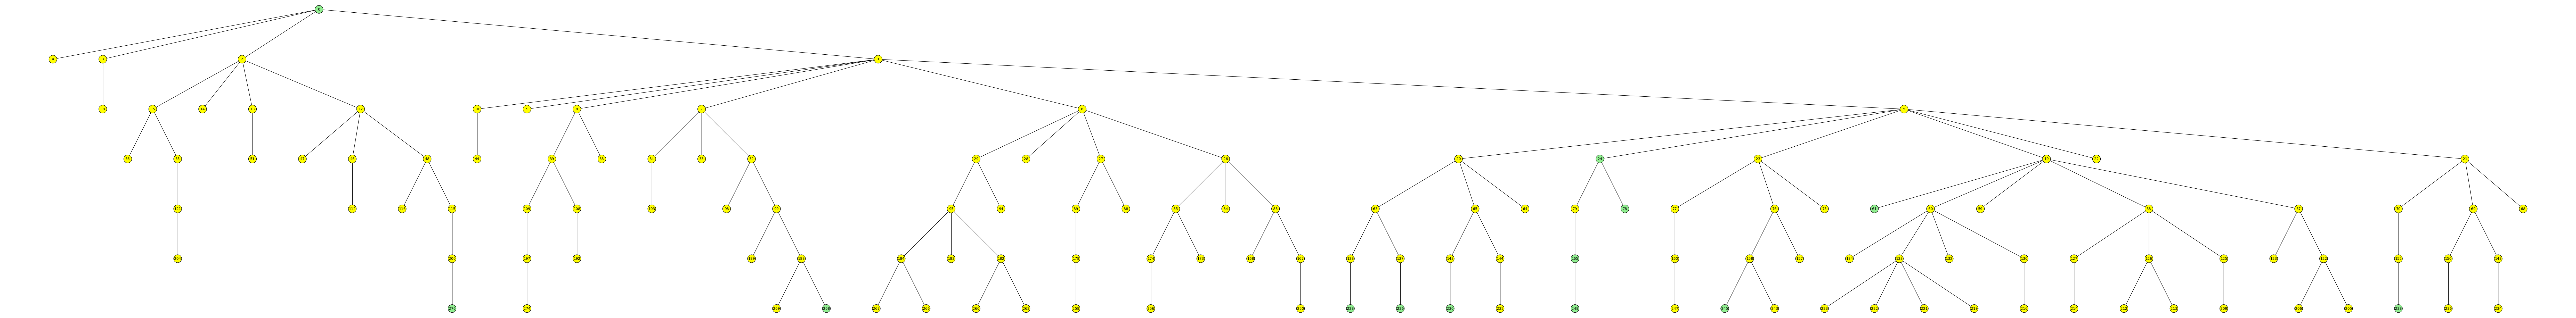

In [31]:
# yellow = non-Coxeter
# green = Coxeter, arithmetic
# blue = Coxeter, non-arithmetic
# red = no check done (diagram too large)
T.plot(layout="tree", tree_root=0, talk=True, vertex_colors=color_facets(T)).show(figsize=[100,100]);

In [32]:
# ---------------------------------------------------------------------- #
# ------- POLYTOPES: a curious 5-dimensional lattice // polytope ------- #
# ---------------------------------------------------------------------- #

In [33]:
#
# Field Q
#
K = QQ;
#
# Outer normals to facets
#
e1 = (0, -1, 1, 0, 0, 0);
e2 = (0, 0, -1, 1, 0, 0);
e3 = (0, 0, 0, -1, 1, 0);
e4 = (0, 0, 0, 0, -1, 1);
e5 = (0, 0, 0, 0, 0, -1);
e6 = (1, 5, 0, 0, 0, 0);
e7 = (1, 3, 3, 0, 0, 0);
e8 = (1, 2, 2, 2, 2, 1);
e9 = (1, 3, 2, 2, 0, 0);
e10 = (1, 3, 2, 1, 1, 1);
e11 = (2, 6, 3, 3, 3, 0);
e12 = (4, 10, 10, 5, 5, 0);
#
# Creating a list of outer normals (roots)
#
roots = list(map(lambda x: vector(x), [e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12]));
#
# Bilinear form associated to L
#
def bL(u, v):
    return (-15)*u[0]*v[0] + u[1:]*v[1:];
#
# Quadratic form associated to L
#
def fL(v):
    return bL(v, v);

In [34]:
#
# Creating the root of the facet tree
# 
d5 = diagram(roots);
a5 = d5.automorphism_group(edge_labels=True);
P = (roots, d5, a5, None, None);
#
# Creating the facet tree
#
T = Graph();
T.add_vertex(0);
T.set_vertex(0,P);
#
# Augmenting the facet tree with faces from codim 1 to codim (dim_polytope)-2
#
dim_polytope = 5;
for codim in range(dim_polytope-2):
    facet_info(T);
    augment_facet_tree(T);
    prune_facet_tree(T);
facet_info(T);

Codimension 0 Coxeter faces.
Face  0  is arithmetic.
Codimension 1 Coxeter faces.
Face  3  is arithmetic.
Face  4  is arithmetic.
Face  5  is arithmetic.
Codimension 2 Coxeter faces.
Face  13  is arithmetic.
Face  21  is arithmetic.
Face  22  is arithmetic.
Face  23  is arithmetic.
Face  26  is arithmetic.
Face  27  is arithmetic.
Face  28  is arithmetic.
Face  31  is arithmetic.
Codimension 3 Coxeter faces.
Face given below is not arithmetic because of (cycle, cyclic product):  [0, 3, 0] 49/4
Face  34  is (properly) quasi-arithmetic.
Face  37  is arithmetic.
Face given below is not arithmetic because of (cycle, cyclic product):  [0, 3, 0] 49/4
Face  43  is (properly) quasi-arithmetic.
Face  44  is arithmetic.
Face given below is not arithmetic because of (cycle, cyclic product):  [0, 2, 0] 16/3
Face  46  is (properly) quasi-arithmetic.
Face  50  is arithmetic.
Face given below is not arithmetic because of (cycle, cyclic product):  [0, 4, 0] 15/2
Face  55  is (properly) quasi-arithmeti

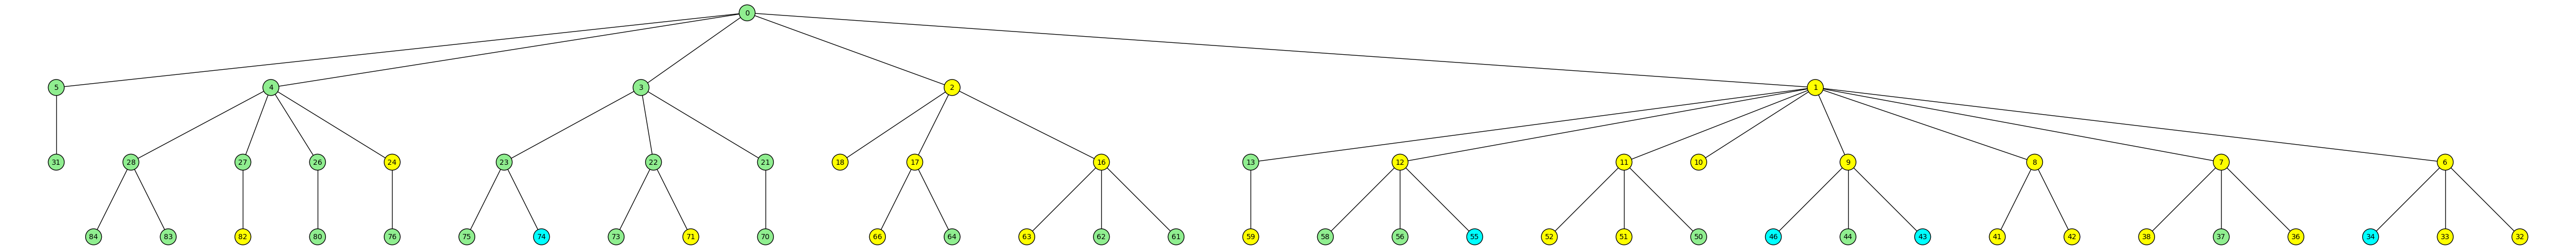

In [35]:
# yellow = non-Coxeter
# green = Coxeter, arithmetic
# blue = Coxeter, non-arithmetic
# red = no check done (diagram too large)
T.plot(layout="tree", tree_root=0, talk=True, vertex_colors=color_facets(T)).show(figsize=[50,50]);

In [36]:
#                                       --> #74
# The chain of faces #0 --> #3 --> #23 /        consists entirely of Coxeter polytopes
#                                      \--> #75
#
# All of them are arithmetic, except for #74, which is properly quasi-arithmetic
#

In [37]:
#
# Gram matrix of P'_1 (face #75)
#
show(Gram_matrix(T.get_vertex(75)[0]));

[           1 -1/2*sqrt(2)           -1]
[-1/2*sqrt(2)            1            0]
[          -1            0            1]

In [38]:
#
# Gram matrix of P'_2 (face #74)
#
show(Gram_matrix(T.get_vertex(74)[0]));

[                   1         -1/2*sqrt(2)         -2/3*sqrt(3)                    0]
[        -1/2*sqrt(2)                    1                    0 -1/2*sqrt(5)*sqrt(2)]
[        -2/3*sqrt(3)                    0                    1                    0]
[                   0 -1/2*sqrt(5)*sqrt(2)                    0                    1]